In [1]:
using Revise

In [12]:
using Model
using LogExpFunctions: softmax
using CairoMakie

In [4]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [134]:
problem = BPatGModel(decisions);

In [137]:
@time post = Model.sample(problem, 500, 1; backend=:ReverseDiff)

240.302933 seconds (1.75 M allocations: 2.878 GiB, 0.29% gc time)


DynamicHMCPosterior with 500 samples and parameters (:zj, :zt, :σj, :σt, :αs)

In [148]:
Model.checkconvergence(post)[end]

Hamiltonian Monte Carlo sample of length 500
  acceptance rate mean: 0.89, 5/25/50/75/95%: 0.64 0.84 0.92 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 18%, 5 => 82%

In [95]:
function topkgroups(groups, k=10)
    js = reduce(vcat, groups)
    df = DataFrame(groups=js)
    df = combine(groupby(df, :groups), nrow => :count)
    df = sort!(df, :count; rev=true)
    first(df.groups, k)
end

topkgroups (generic function with 2 methods)

In [103]:
function marginaleffects(post, element; group=:judges)
    params = if group == :judges
        (zs=:zj, σs=:σj)
    elseif group == :cpc
        (zs=:zt, σs=:σt)
    else
        throw(ArgumentError("Unknown group."))
    end

    map(post) do s
        zs = getproperty(s, params.zs)
        ze = getindex(zs, element)
        σs = getproperty(s, params.σs)
        αs = s.αs 
        softmax(vcat(0, αs .+ ze .* σs))
    end
end

marginaleffects (generic function with 1 method)

In [125]:
function plot_marginal_probabilities!(ax, probs)
    for (i, vals) in enumerate(eachcol(hcat(probs...)'))
        m, sd = mean(vals), std(vals)
        errorbars!(ax, [i], [m], [sd]; cycle=:color)
        scatter!(ax, i, m)
    end    
end
function plot_marginal_probabilities(problem, post, groups::Vector{Int}; ncols=4, label="Element")
    fig = Figure()
    for (i, group) in enumerate(groups)
        probs = marginaleffects(post, group)
        pos = fldmod1(i, ncols)
        ax = Axis(fig[pos...]; subtitle = "$label $group")
        plot_marginal_probabilities!(ax, probs)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    colors = Makie.wong_colors()
    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3)
    
    fig
end

plot_marginal_probabilities (generic function with 2 methods)

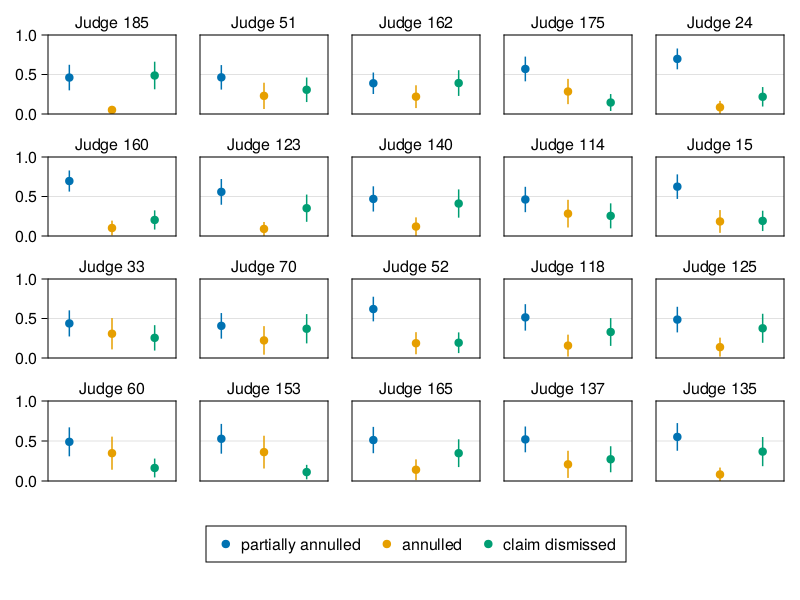

In [138]:
judges = topkgroups(problem.js, 20)
plot_marginal_probabilities(problem, post, judges; label="Judge", ncols=5)

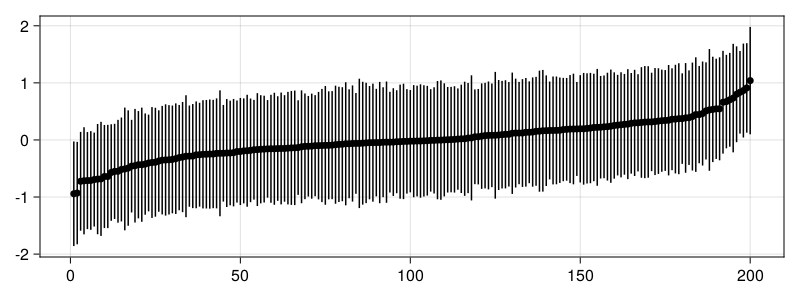

In [181]:
let 
    βs = map(post) do s
        map(last, s.zj)
    end
    means,sds = mean(βs), std(βs)
    idx = sortperm(means)

    fig = Figure(resolution=(800, 300))
    ax = Axis(fig[1,1])
    errorbars!(ax, eachindex(means), means[idx], sds[idx])
    scatter!(ax, eachindex(means), means[idx]; color=:black, markersize=10)
    fig
end

In [141]:
function plot_densities(draws)
    fig = Figure()
    ax1 = Axis(fig[1,1])
    hist!(first.(draws); label="annulled")
    hist!(last.(draws); label="claim dismissed")
    axislegend(ax1)
    fig
end

plot_densities (generic function with 1 method)

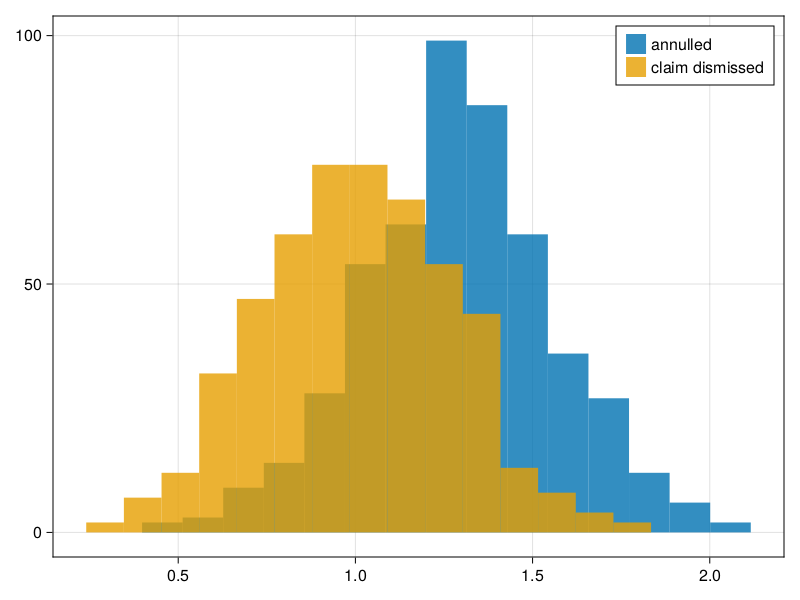

In [144]:
plot_densities(post.σj)